In [1]:
import os

DATASET = "VehicleDamage"
REPO_PATH = os.path.join(os.path.abspath(os.path.join(os.getcwd(), "../..")),)
print(REPO_PATH)

/home/maxlaptop/Documents/Vehicle-Damage-Localisation


In [2]:
import torch
from hydra.utils import instantiate

import hydra
import sys
import os

import logging
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger("matplotlib").setLevel(logging.ERROR)

sys.path.append(REPO_PATH)
os.chdir(REPO_PATH)

In [3]:
import wandb

wandb.init(mode="disabled")

try:
    hydra.core.global_hydra.GlobalHydra.instance().clear()
except:
    pass

hydra.initialize(version_base="1.2", config_path="../../src/")
cfg = hydra.compose(
    "main.yaml",
    overrides=[
        "+data=data",
        f"+data/dataset={DATASET}",
    ],
)

print(cfg)
device = torch.device("cpu")
data = instantiate(cfg.data, device=device, model_transforms=[], _recursive_=False)

DEBUG:git.cmd:Popen(['git', 'version'], cwd=/home/maxlaptop/Documents/Vehicle-Damage-Localisation, stdin=None, shell=False, universal_newlines=False)
DEBUG:git.cmd:Popen(['git', 'version'], cwd=/home/maxlaptop/Documents/Vehicle-Damage-Localisation, stdin=None, shell=False, universal_newlines=False)
DEBUG:wandb.docker.auth:Trying paths: ['/home/maxlaptop/.docker/config.json', '/home/maxlaptop/.dockercfg']
DEBUG:wandb.docker.auth:No config file found
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
DEBUG:wandb:no default config file found in config-defaults.yaml
DEBUG:hydra.core.utils:Setting JobRuntime:name=UNKNOWN_NAME
DEBUG:hydra.core.utils:Setting JobRuntime:name=notebook
{'device': 'cuda:0', 'seed': 42, 'wandb': {'project': 'Vehicle-Damage-Localisation', 'group': None, 'mode': 'online', 'dir': 'outputs/', 'name': None, 'reinit': True}, 'data': {'dataloaders': {'train_loade

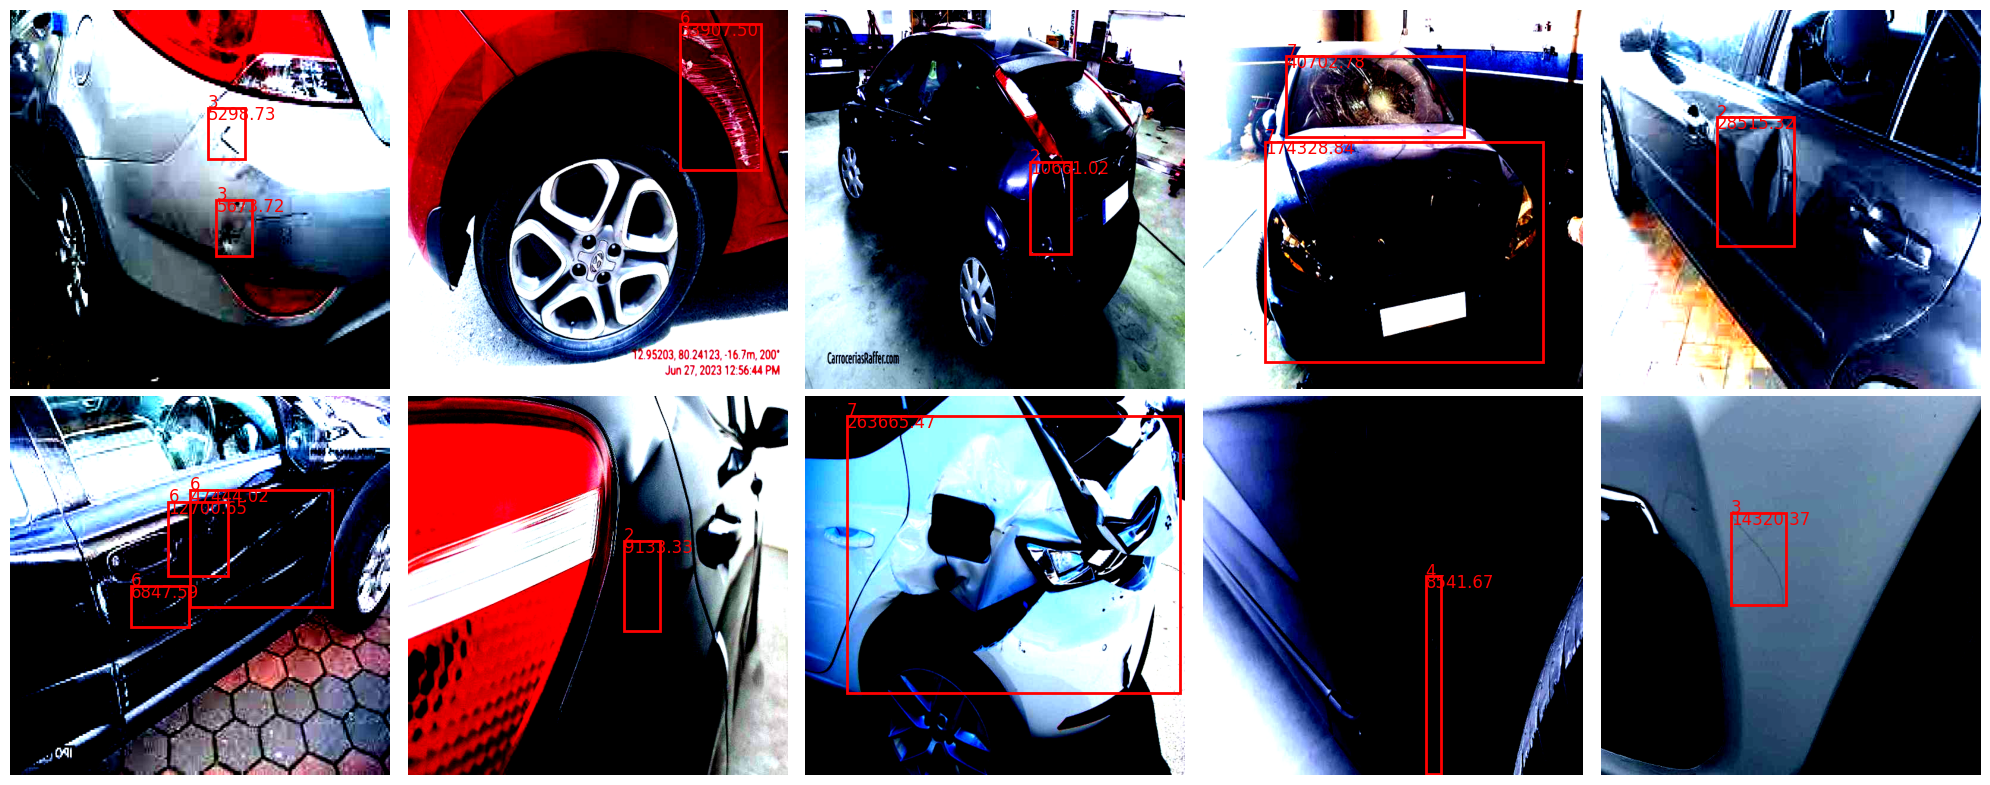

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class BreakAllLoops(Exception):
    pass

# Define the main function to process and plot multiple images
def plot_images_with_bboxes(dataloader, num_images=10, rows=2):
    """
    Plots images with bounding boxes in a tileplot.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader containing images and bounding boxes.
        num_images (int): Number of images to plot. Default is 10.
    """
    fig, axes = plt.subplots(rows, num_images//rows, figsize=(20, 8))  # Create a grid of 2 rows x 5 columns
    axes = axes.flatten()

    image_counter = 0
    try:
        for i, (img, target) in enumerate(dataloader):
            for _img, _target in zip(img, target):
                ax = axes[image_counter]
                img_np = _img.permute(1, 2, 0).cpu().numpy()  # Convert to numpy format for plt.imshow
                ax.imshow(img_np)

                # Draw bounding box
                for bbox, label, area in zip(_target['boxes'], _target['labels'], _target['area']):
                    _bbox = bbox.cpu().numpy()
                    rect = patches.Rectangle(
                        (_bbox[0], _bbox[1]), _bbox[2] - _bbox[0], _bbox[3] - _bbox[1],
                        linewidth=2, edgecolor='r', facecolor='none'
                    )
                    ax.add_patch(rect)
                    ax.text(_bbox[0], _bbox[1], label.item(), color='r', fontsize=12)
                    ax.text(_bbox[0], _bbox[1] + 20, f'{area:.2f}', color='r', fontsize=12)
                ax.axis('off')  # Turn off axis
                image_counter += 1
                if image_counter >= num_images:
                    raise BreakAllLoops
    except BreakAllLoops:
        pass

    # Remove extra axes if not all are used
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_with_bboxes(data.train_loader, num_images=10)
